In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib
#this is the sms spam identification project

In [9]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data = data.rename(columns={"v1": "label", "v2": "message"})["label message".split()]


In [11]:
print("Dataset head:\n", data.head())
print("Dataset info:\n", data.info())
print("Label distribution:\n", data['label'].value_counts())


Dataset head:
   label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
Dataset info:
 None
Label distribution:
 ham     4825
spam     747
Name: label, dtype: int64


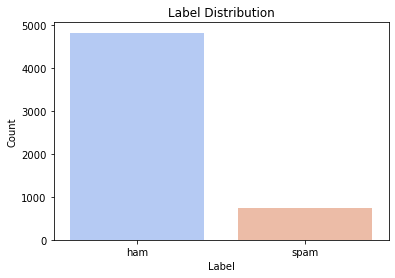

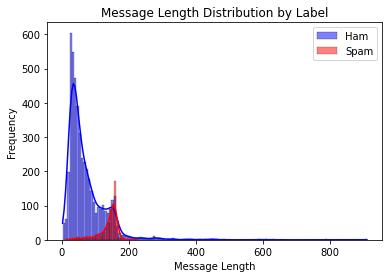

In [13]:
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=data, palette='coolwarm')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Message length analysis
data['message_length'] = data['message'].apply(len)
plt.figure(figsize=(6, 4))
sns.histplot(data[data['label'] == 'ham']['message_length'], color='blue', kde=True, label='Ham')
sns.histplot(data[data['label'] == 'spam']['message_length'], color='red', kde=True, label='Spam')
plt.title("Message Length Distribution by Label")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.legend()
plt.show()


Top Words in Spam Messages:


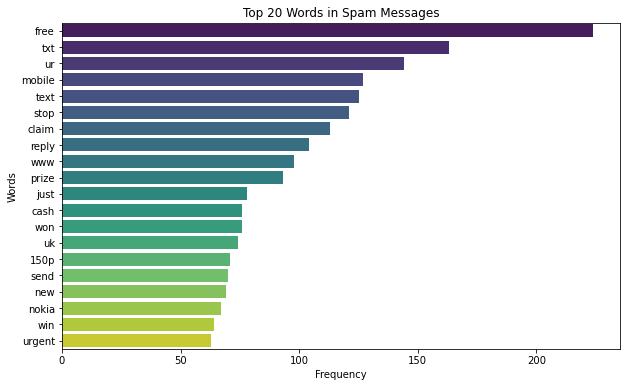

Top Words in Ham Messages:


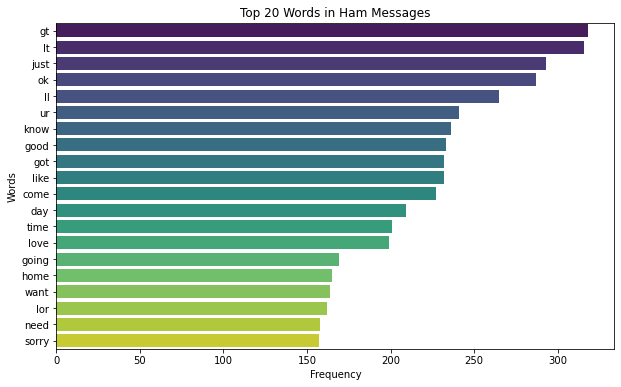

In [15]:

def plot_top_words(label, top_n=20):
    messages = data[data['label'] == label]['message']
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform(messages)
    word_sum = np.array(word_counts.sum(axis=0)).flatten()
    words = vectorizer.get_feature_names_out()
    top_indices = word_sum.argsort()[-top_n:][::-1]
    top_words = [(words[i], word_sum[i]) for i in top_indices]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[word[1] for word in top_words], y=[word[0] for word in top_words], palette='viridis')
    plt.title(f"Top {top_n} Words in {'Spam' if label == 'spam' else 'Ham'} Messages")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()

print("Top Words in Spam Messages:")
plot_top_words('spam')

print("Top Words in Ham Messages:")
plot_top_words('ham')

/tmp/ipykernel_244/1828706667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_features['label'] = correlation_features['label'].map({'ham': 0, 'spam': 1})


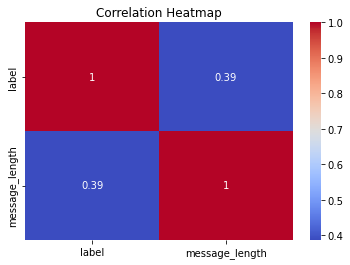

In [19]:
correlation_features = data[['label', 'message_length']]
correlation_features['label'] = correlation_features['label'].map({'ham': 0, 'spam': 1})
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_features.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


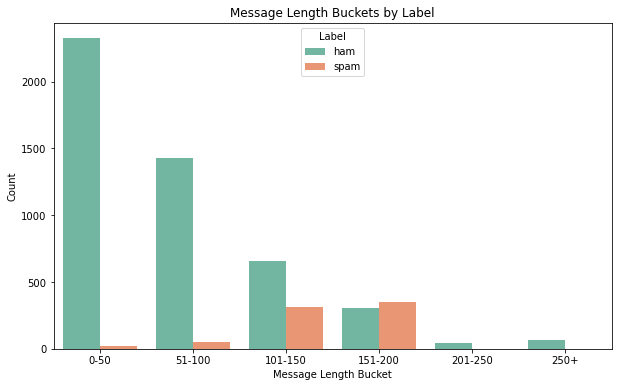

In [21]:
data['length_bucket'] = pd.cut(data['message_length'], bins=[0, 50, 100, 150, 200, 250, np.inf], labels=['0-50', '51-100', '101-150', '151-200', '201-250', '250+'])
plt.figure(figsize=(10, 6))
sns.countplot(x='length_bucket', hue='label', data=data, palette='Set2')
plt.title("Message Length Buckets by Label")
plt.xlabel("Message Length Bucket")
plt.ylabel("Count")
plt.legend(title="Label")
plt.show()

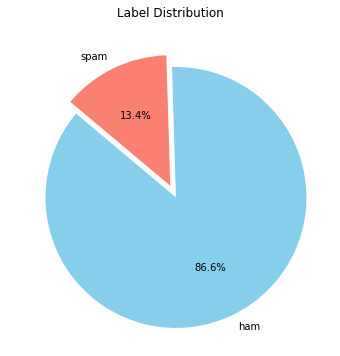

In [23]:
plt.figure(figsize=(6, 6))
data['label'].value_counts().plot.pie(autopct="%1.1f%%", colors=['skyblue', 'salmon'], startangle=140, explode=(0.1, 0))
plt.title("Label Distribution")
plt.ylabel("")
plt.show()

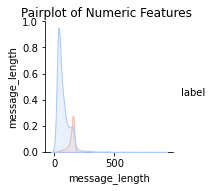

In [25]:
sns.pairplot(correlation_features, hue='label', palette='coolwarm')
plt.suptitle("Pairplot of Numeric Features", y=1.02)
plt.show()

In [27]:
# Preprocessing
data['message'] = data['message'].str.lower().str.replace(r'[^\w\s]', ' ').str.replace(r'\s+', ' ')
data['message_length'] = data['message'].apply(len)

/tmp/ipykernel_244/197674826.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['message'] = data['message'].str.lower().str.replace(r'[^\w\s]', ' ').str.replace(r'\s+', ' ')


In [29]:
X = data['message']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [31]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [35]:
import pickle
with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf, file)

In [37]:
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear', probability=True)
}

params = {
    "Naive Bayes": {'alpha': [0.1, 0.5, 1.0]},
    "Logistic Regression": {'C': [0.01, 0.1, 1.0, 10]},
    "Support Vector Machine": {'C': [0.1, 1, 10]}
}

best_estimators = {}
for model_name, model in models.items():
    print(f"Tuning {model_name}...")
    grid = GridSearchCV(model, params[model_name], scoring='accuracy', cv=5)
    grid.fit(X_train_tfidf, y_train)
    best_estimators[model_name] = grid.best_estimator_
    print(f"Best parameters for {model_name}: {grid.best_params_}")


Tuning Naive Bayes...
Best parameters for Naive Bayes: {'alpha': 0.1}
Tuning Logistic Regression...
Best parameters for Logistic Regression: {'C': 10}
Tuning Support Vector Machine...
Best parameters for Support Vector Machine: {'C': 10}


In [39]:
# Evaluate Models
for model_name, model in best_estimators.items():
    print(f"Evaluating {model_name}...")
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("-" * 50)

Evaluating Naive Bayes...
Naive Bayes Accuracy: 0.9844497607655502
Confusion Matrix:
[[1442    6]
 [  20  204]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99      1448
        spam       0.97      0.91      0.94       224

    accuracy                           0.98      1672
   macro avg       0.98      0.95      0.97      1672
weighted avg       0.98      0.98      0.98      1672

--------------------------------------------------
Evaluating Logistic Regression...
Logistic Regression Accuracy: 0.9814593301435407
Confusion Matrix:
[[1446    2]
 [  29  195]]
Classification Report:
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1448
        spam       0.99      0.87      0.93       224

    accuracy                           0.98      1672
   macro avg       0.99      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672

---------

In [41]:
best_model_name = max(best_estimators, key=lambda name: accuracy_score(y_test, best_estimators[name].predict(X_test_tfidf)))
best_model = best_estimators[best_model_name]
with open('spam_classifier_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

print(f"Best model '{best_model_name}' saved for deployment!")

Best model 'Naive Bayes' saved for deployment!


In [79]:
import re

def preprocess_message(message):
    message = message.lower()  
    message = re.sub(r'[^\w\s]', ' ', message)  
    message = re.sub(r'\s+', ' ', message).strip()  
    return message
def predict_message(message):
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        vectorizer = pickle.load(file)
    with open('spam_classifier_model.pkl', 'rb') as file:
        model = pickle.load(file)
    processed_message = preprocess_message(message)
    features = vectorizer.transform([processed_message])
    prediction = model.predict(features)
    return prediction[0]

In [81]:
example_message = "SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info"
preprocess_message(example_message)
print(f"Prediction: {predict_message(example_message)}")

Prediction: spam


In [ ]:
#model predicted spam correctly